In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

# Getting and preparing the data

In [4]:
bank_data = pd.DataFrame(pd.read_csv('bank-full.csv', delimiter=';'))

## checking if dataset contains any null values. It doesn't, so we don't have to handle any missing data
bank_data.isnull().values.any()     
bank_data  ## display data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [5]:
X = bank_data.drop(['y'], 1)
y = np.array(bank_data[['y']])
y = np.ravel(y)   # flattens an array

In [6]:
columns_to_transform = [1,2,3,4,6,7,8,10,15]  #columns containing any categorical data, that need to be transformed
transformer = ColumnTransformer([('encoder', OneHotEncoder(), columns_to_transform)], remainder='passthrough')

X = transformer.fit_transform(X)

In [14]:
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

Scaling the data

In [8]:
scaler_x = StandardScaler().fit(X)  # data standarization
X = scaler_x.transform(X)

# Building a train and test sets 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

# Hyperparameters tuning

In [10]:
def tune_parameters(clf, train_results, test_results):
    train_pred = clf.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)  

In [11]:
def auc_plot(lst, train, test, xlabel):
    line1, = plt.plot(lst, train, 'b')  # blue line representing AUC curve of train data
    line2, = plt.plot(lst, test, 'r')   # red line representing AUC curve of test data performance
    plt.xlabel(xlabel)
    plt.ylabel('AUC score')

# K-Nearest Neighbors Classifier

Tuning hyperparameters of given classifiers. Every parameter is splitted to another cell out of two reasons: readability and increasing optimalization of computations. Due to size of given dataset (over 40000 records), fitting every parameter at once would take horrendous amounts of time.

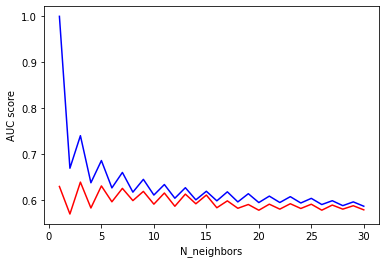

In [11]:
# picking best n_neighbors number
neighbors = list(range(1,31))

train_results, test_results = [],[]

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    tune_parameters(knn, train_results, test_results)

auc_plot(neighbors, train_results, test_results, 'N_neighbors')

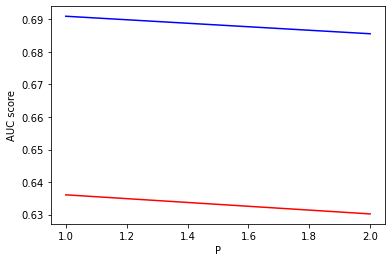

In [12]:
# picking best P value
ps = [1,2]

train_results, test_results = [],[]

for p in ps:
    knn = KNeighborsClassifier(p=p).fit(X_train, y_train)
    tune_parameters(knn, train_results, test_results)

auc_plot(ps, train_results, test_results, 'P')

In [12]:
knn = KNeighborsClassifier(n_neighbors = 4, p=1).fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_pred, y_test)
cm

array([[7846,  840],
       [ 132,  225]], dtype=int64)

RESULT OF TUNED KNN CLASSIFIER

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7978
           1       0.63      0.21      0.32      1065

    accuracy                           0.89      9043
   macro avg       0.77      0.60      0.63      9043
weighted avg       0.87      0.89      0.87      9043

